# Lab 6
# Kevin Liang - kgl392
# Matthew Tan - mmt2338

In [215]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sympy
import scipy
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import collections
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.decomposition import PCA


Mean beta hat: 0.745447730474
Variance beta hat: 9.52456950954

Alpha / MSE
0.01 : 2.87045193125e-05
0.1 : 0.00874055532396
1 : 0.119996489473
10 : 1.35616856545
100 : 16.3178681573
200 : 23.0268307572
300 : 20.6278303802
400 : 38.7276113761
500 : 46.4410933092


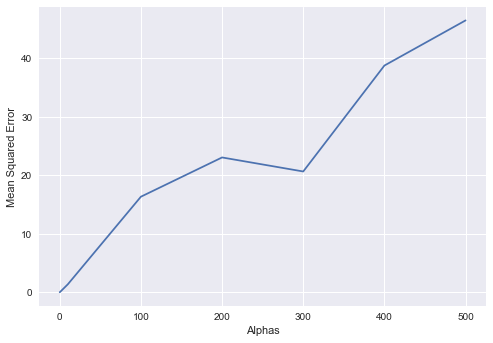

In [216]:
# Question 1

# helper function to calculate rmse of a model
def rmse_cv(model, X, y):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

beta_hat_components = []

for _ in range(100):
    X = np.random.randn(51,50)
    noise = np.asarray([np.random.normal(0,.25,51)]).transpose()
    beta = np.asarray([[1]*50]).transpose()
    y = np.dot(X, beta) + noise
    
    lr = LinearRegression()
    lr = lr.fit(X,y)
    beta_hat_components.append(lr.coef_[0,0])

mean_beta_hat = np.mean(beta_hat_components)
variance_beta_hat = np.var(beta_hat_components)

print "Mean beta hat: " + str(mean_beta_hat)
print "Variance beta hat: " + str(variance_beta_hat) + '\n'

alphas = [0.01,0.1,1,10,100,200,300,400,500]
performance = {}
performance_list = []
for alpha in alphas:
    X = np.random.randn(51,50)
    noise = np.asarray([np.random.normal(0,.25,51)]).transpose()
    beta = np.asarray([[1]*50]).transpose()
    y = np.dot(X, beta) + noise
    
    rr = Ridge(alpha)
    rr = rr.fit(X,y)
    y_pred = rr.predict(X)
    rmse = mean_squared_error(y,y_pred)
    performance[alpha] = rmse
    performance_list.append(rmse)

performance = collections.OrderedDict(sorted(performance.items(), key=lambda t: t[0]))
print "Alpha / MSE"
for x in performance:
    print str(x) + " : " + str(performance[x])

plt.xlabel("Alphas")
plt.ylabel("Mean Squared Error")
plt.plot(alphas,performance_list)
plt.show()



In [217]:
# Helper function for calculating test error
def testError(true, predict):
    sum = 0
    for x in range(len(true)):
        sum += abs(true[x] - predict[x])
    return (float(sum)/float(len(true)))

In [218]:
# Question 2 

path = "D:/Kevin Liang/Documents/1_UT_SENIOR/UT_AUSTIN_FALL_2017/EE_379K/Lab6/"
data = pd.read_csv(path + "College.csv", header = 0, index_col = 0)

X = data.drop(["Apps"], axis = 1).replace({"Yes" : 1, "No" : 0})
y = data.loc[:,"Apps"]

X.fillna(X.mean())
# Part a
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, y, test_size=0.5, random_state=0)

# Part b
lr = LinearRegression()
lr = lr.fit(X_train, Y_train)
y_pred = lr.predict(X_test)

print "Part B: Linear Model"
print "Linear Regression test error: " + str(testError(Y_test, y_pred)) + '\n'

# Part c
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
r_cv = RidgeCV(alphas = alphas)
r_cv = r_cv.fit(X_train, Y_train)
y_pred = r_cv.predict(X_test)

print "Part C: Ridge Regression"
print "RidgeCV test error: " + str(testError(Y_test, y_pred)) + '\n'

# Part d
alphas = [10, 1, 0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]
l_cv = LassoCV(alphas = alphas)
l_cv = l_cv.fit(X_train, Y_train)
y_pred = l_cv.predict(X_test)


non_zero_coefs = sum(l_cv.coef_ < 0.1)

print "Part D: Lasso Regression"
print "LassoCV test error: " + str(testError(Y_test, y_pred))
print "LassoCV Non-zero coefficients: " + str(non_zero_coefs) + '\n'

# Part e

print "Part E: PCR"
components = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

component = 0
total_variance = 0

print "# of Components / Negative Cross Val Score / Variance"
for x in components:
    pca = PCA(n_components = x, svd_solver = "full")
    cv_score = -1 * cross_val_score(pca, X, y, cv=10).mean()
    pca  = pca.fit(X_train, Y_train)
    print x, cv_score, pca.explained_variance_ratio_[-1]
    if total_variance < .9:
        total_variance += pca.explained_variance_ratio_[-1]
        component = x

pcr = LinearRegression()
pcr = pcr.fit(X_train.iloc[:,:component+1], Y_train)
X_test_pcr = X_test.iloc[:,:component+1]
y_pred = pcr.predict(X_test_pcr)

print
print "Value of M: " + str(component)
print "PCR test error: " + str(testError(Y_test, y_pred)) + '\n'

# Part f
print "Part F: PLS"
component = 0
score = 0
print "# of Components / Negative Cross Val Score "
for x in components:
    pls = PLSRegression(n_components = x)
    cv_score = -1 * cross_val_score(pls, X, y, cv=10).mean()
    pca  = pca.fit(X_train, Y_train)
    if cv_score < score:
        score = cv_score
        component = x
    print x, cv_score
    
pls = PLSRegression(n_components = component)
pls = pls.fit(X_train, Y_train)
y_pred = pls.predict(X_test)

print
print "Value of M: " + str(component)
print "PLS test error: " + str(testError(Y_test, y_pred)) 



Part B: Linear Model
Linear Regression test error: 624.660775993

Part C: Ridge Regression
RidgeCV test error: 622.457778984

Part D: Lasso Regression
LassoCV test error: 619.474419861
LassoCV Non-zero coefficients: 12

Part E: PCR
# of Components / Negative Cross Val Score / Variance
1 151.450077808 0.464469281632
2 142.210329382 0.421237161864
3 137.360385262 0.066225839805
4 136.131576067 0.0245646109023
5 133.042173388 0.0107896991109
6 128.891589544 0.00689200685852
7 121.373433483 0.00489320342696
8 118.462067767 0.000561970743338
9 106.776980961 0.000354534653025
10 105.721427804 5.48810197432e-06
11 105.135562708 2.65542799489e-06
12 104.423597828 1.89712912486e-06
13 103.847556874 8.58009222647e-07
14 103.637208138 3.9755368977e-07
15 102.991410149 2.80811922305e-07
16 101.305593475 1.13071667094e-07
17 101.305593487 8.98421317377e-10

Value of M: 3
PCR test error: 642.966739894

Part F: PLS
# of Components / Negative Cross Val Score 
1 -0.0926313503776
2 -0.053376231728
3 0.0

# Part E (PCR)

To determine the M value for PCR, I utilized the Negative cross val score and variance of the data. The negative cross val score decreased as the number of components increased so based on the negative cross val score the more components the better the regressional model; however, I based the M value on variance as well. I chose the number of components once 90% of the variance of the data was represented. 


# Part F

I chose the M value for PLS based on the negative cross val score. I chose the largest negative cross val score to determine the number of components to use and thus the M value.

# Part G

Most of the test errors for all of the different regressional models are about the same; however, PLS has a very different test error of 2175 when the other test errors fall between 600 - 650. 

In [219]:
# Question 3 

df = pd.read_csv(path + "boston.csv")
X = df.loc[:,("zn", "indus", "chas", "nox", "rm", "age", "dis", "rad", "tax", "ptratio", "black", "lstat", "medv")]
Y = df.loc[:,"crim"]
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.5, random_state=0)

# Ridge Regression
boston_ridge = RidgeCV(alphas=[0.001, 0.01, .05, 0.1, 0.5, 0.7, 0.9, 1, 2, 5, 7, 10, 20, 30, 40, 45, 50, 55, 60, 70])
boston_ridge.fit(X_train,Y_train)
bridge_cv =  cross_val_score(estimator=boston_ridge, X=X, y=Y, cv=10)
print "Ridge Regression CV error: " + str(-1 * bridge_cv.mean()) + "\n"

#Lasso Regression
boston_lasso = LassoCV(alphas=[10, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005])
boston_lasso.fit(X_train,Y_train)
blasso_cv = cross_val_score(estimator=boston_lasso, X=X, y=Y, cv=10)
print "Lasso Regression CV error: " + str(-1 * blasso_cv.mean()) + "\n"

#PCR 
components = [1,2,3,4,5,6,7,8,9,10,11,12,13]

component = 0
total_variance = 0
score = 0

for x in components:
    pca = PCA(n_components = x, svd_solver = "full")
    cv_score = -1 * cross_val_score(pca, X, Y, cv=10).mean()
    pca  = pca.fit(X_train, Y_train)
    #print x, cv_score, pca.explained_variance_ratio_[-1]
    if total_variance < .9:
        total_variance += pca.explained_variance_ratio_[-1]
        score = cv_score
        component = x
        
print "# of componenents for PCR: " + str(component) #number of components
print "CV_score for the given number of components: " + str(cv_score)  #the score given the number of components
boston_pcr = LinearRegression()
boston_X_test_pcr = X_test.iloc[:,:component+1]
boston_pcr = cross_val_score(estimator=boston_pcr, X=X, y=Y, cv=10)

Ridge Regression CV error: 166.027381249

Lasso Regression CV error: 148.449354001

# of componenents for PCR: 2
CV_score for the given number of components: 39.3688727427


In [220]:
# Problm 3 - Continued (Subset Selection code)
# Recursive Feature Elimination

# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()
# converting Y to a useable data type
Y_int  = (1000*Y).astype(int) 
minimum = 1000.0;
a = [];
# create the RFE model and select 3 attributes
for i in range(5,13):
    rfe = RFE(estimator=model, n_features_to_select=i)
    rfe = rfe.fit(X, Y_int)
    rfe_cv = cross_val_score(rfe, X, Y_int, cv=5)
    print rfe_cv
    if(rfe_cv.mean() < minimum):
        a = rfe.support_
        minimum = rfe_cv.mean()
print a
print minimum

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[ 0.0075      0.01388889  0.03703704  0.          0.        ]
[ 0.005       0.01388889  0.03703704  0.          0.        ]
[ 0.005  0.     0.     0.     0.   ]
[ 0.005  0.     0.     0.     0.   ]
[ 0.0075      0.04166667  0.          0.          0.        ]
[ 0.01        0.04166667  0.          0.          0.        ]
[ 0.005       0.02777778  0.          0.          0.        ]
[ 0.0075      0.01388889  0.          0.          0.        ]
[False  True False False  True False  True  True False  True False  True
  True]
0.001


Problem 3 part B:

The model that best performed on the boston.csv data set was the SubsetSelection model, particularly using 7 or 8 of the features. Less than 5 features were not tested since 5 is the standard number of folds (cv=5), and you cannot have fewer features than folds. 

In particular the desired features are as follows: indus, rm, dis, rad, ptratio, lstat, medv

This is decided due to having the smallest CV error (0.001) out of all regression options chosen. The next best regression option was Ridge Regression (0.0791994546446 CV Error value).

Problem 3 part C:

The chosen model does not include all features, as the purpose of subset selection is to discard noisy/unrelated features in order to simplify the data set and regression. In our case, 6 of the 13 were not deemd relevant features, with 7 remaining and listed above in part B.
